In [67]:
"""
Bankruptcy prediction pipeline (cleaned + English comments)

Steps:
1. Load data
2. Encode target
3. Drop redundant columns
4. Create financial ratios (features)
5. Prepare X / y
6. Train/test split (random; for time series use time-based split)
7. Balance training set with SMOTE
8. Scale features
9. Train chosen model (RandomForest / XGBoost / Logistic / SVM)
10. Compute predicted probabilities on test set
11. Define investment styles as cost matrices
12. Search thresholds to maximize expected return per style
13. Compare against simple baselines and plot results
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score

from imblearn.over_sampling import SMOTE

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV




In [69]:
# ---------------------------
# 1) Load data
# ---------------------------
df = pd.read_csv("american_bankruptcy.csv")
# peek
print("Data shape:", df.shape)
df.head(3)



Data shape: (78682, 21)


,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514


Reloaded original CSV shape: (78682, 21)


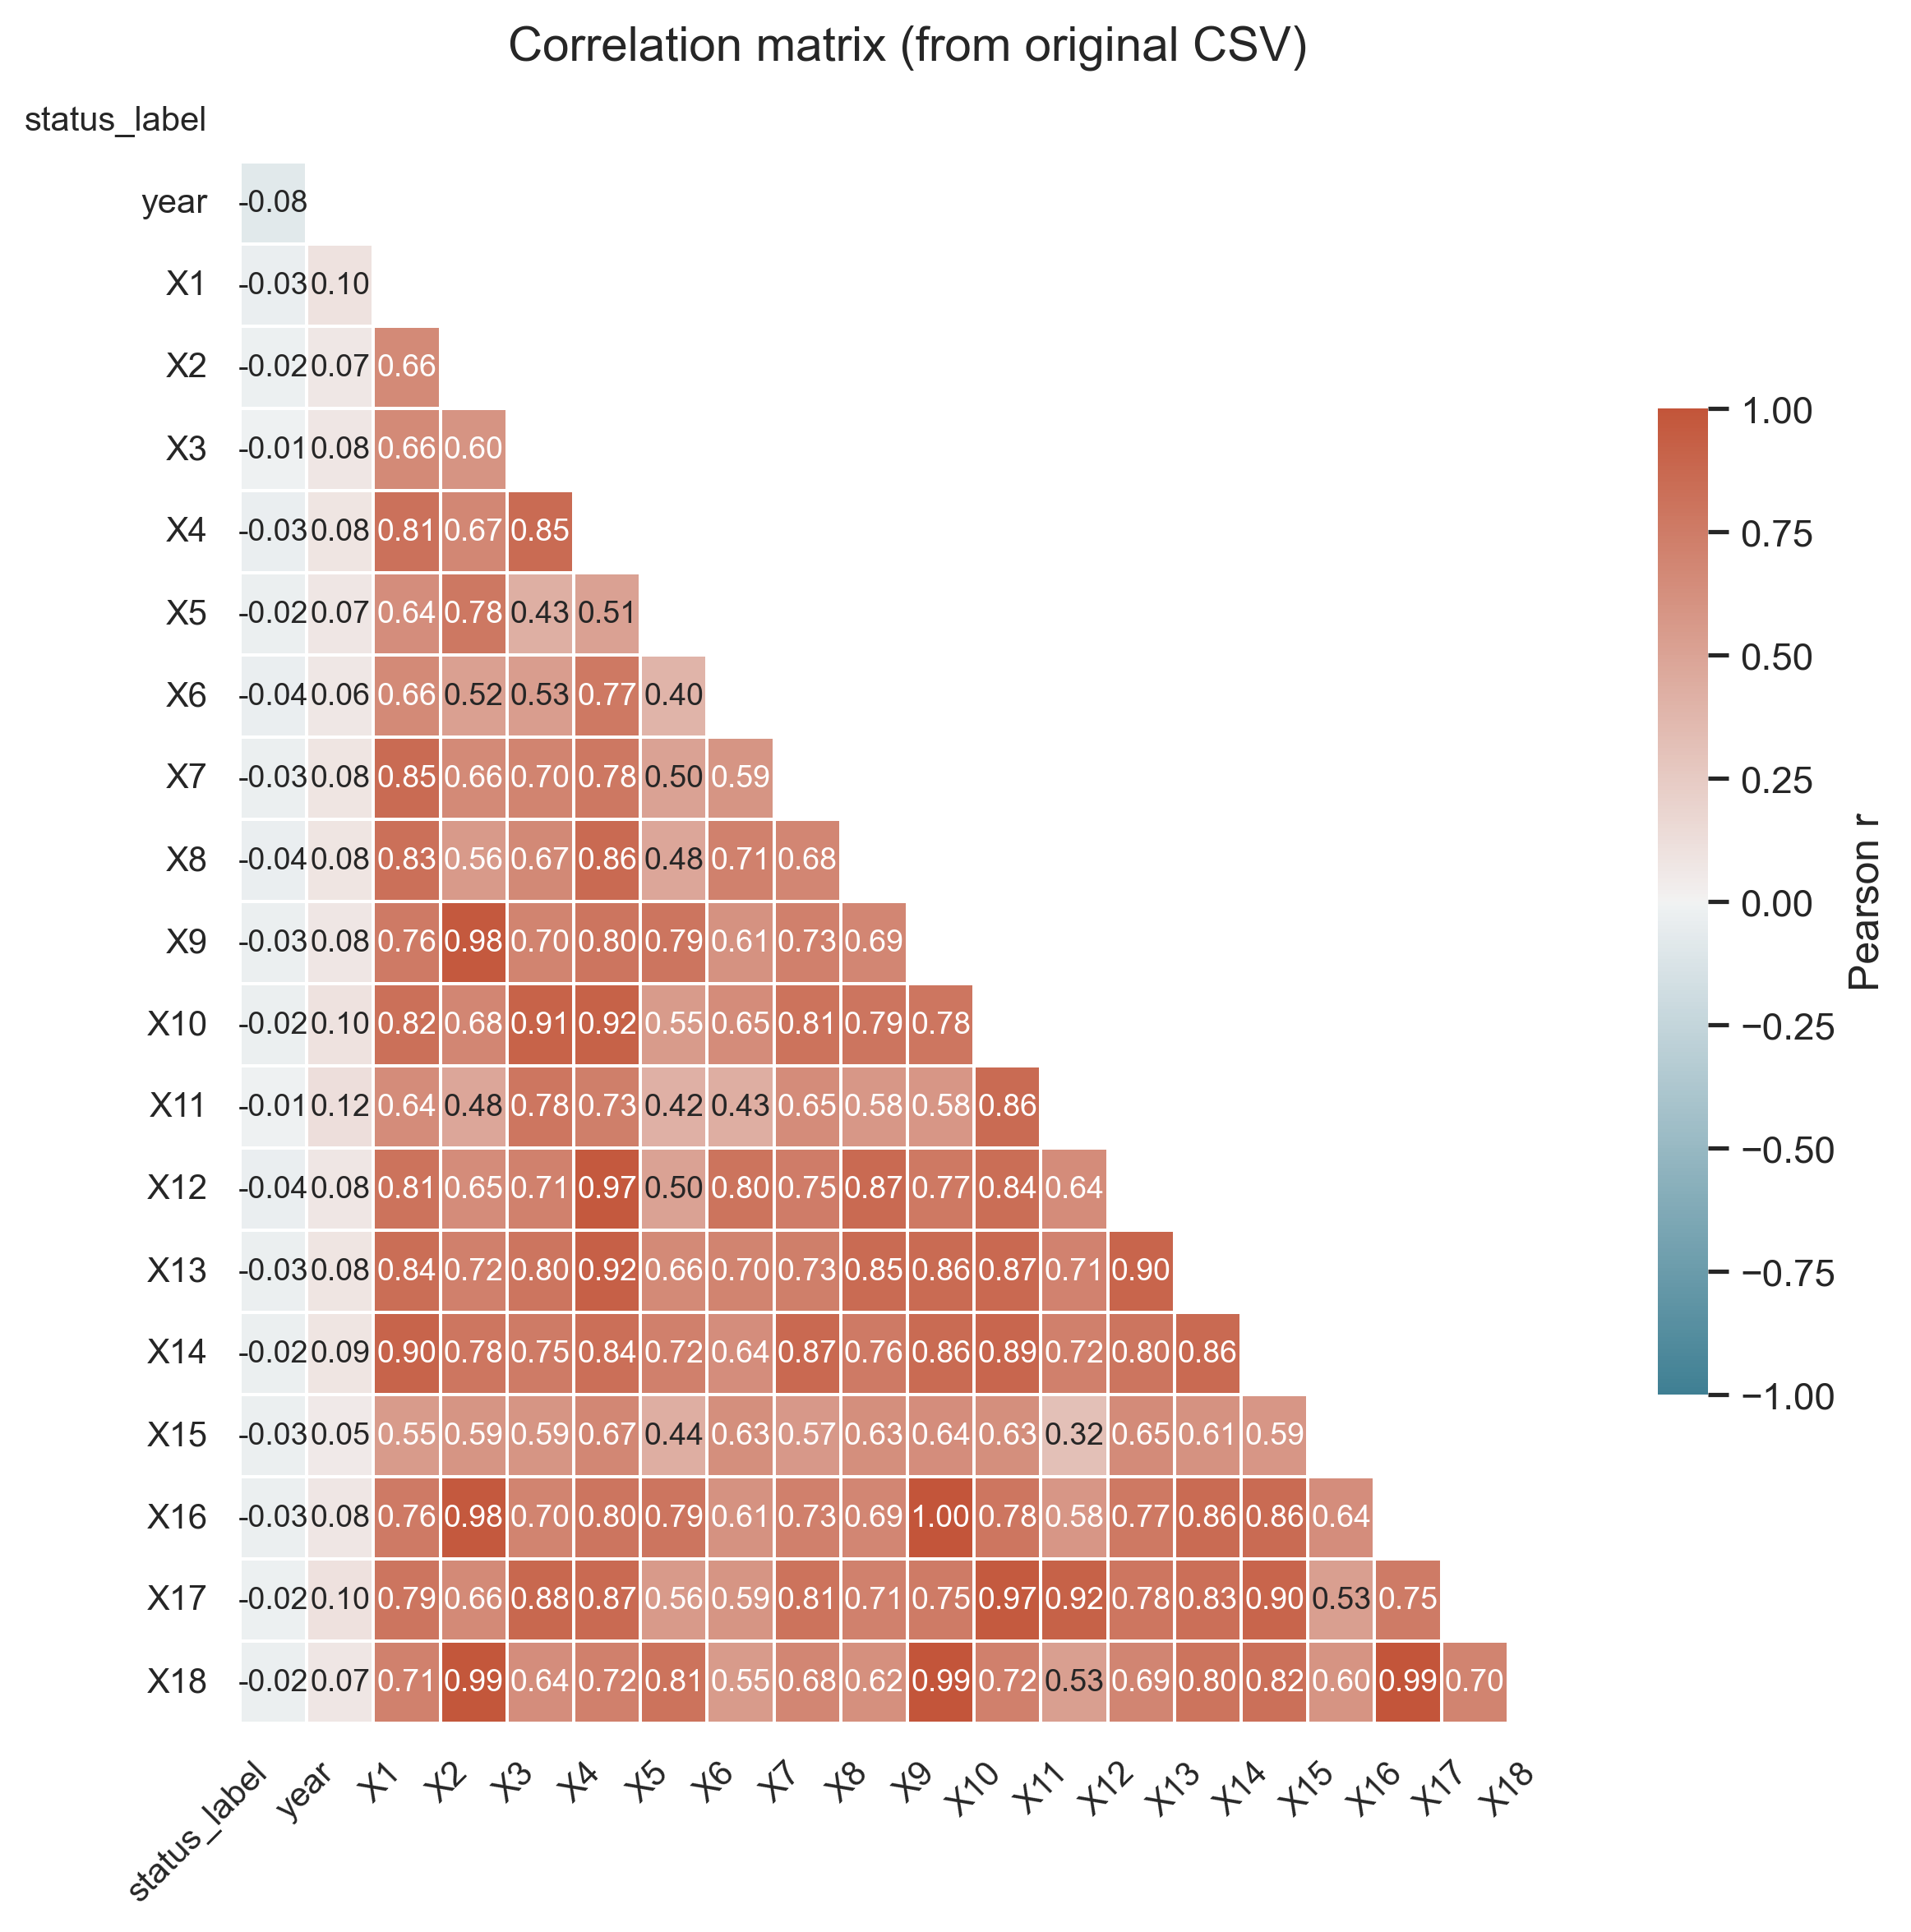

In [71]:
# ===== Re-run correlation using the original CSV to recover any dropped columns =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

csv_path = "american_bankruptcy.csv"   # adjust path if needed
target_col = "status_label"
max_features_to_plot = 25
dpi = 300

# Reload original CSV to ensure we have untouched columns
df_orig = pd.read_csv(csv_path)
print("Reloaded original CSV shape:", df_orig.shape)

# If target is still categorical, map it
if target_col in df_orig.columns and not np.issubdtype(df_orig[target_col].dtype, np.number):
    df_orig[target_col] = df_orig[target_col].map({"alive": 0, "failed": 1})

# Select numeric columns only
numeric = df_orig.select_dtypes(include=[np.number]).copy()
if target_col in df_orig.columns and target_col not in numeric.columns:
    # ensure target included
    numeric[target_col] = df_orig[target_col].astype(float)

if numeric.shape[1] == 0:
    raise RuntimeError("No numeric columns found in the original CSV.")

# Compute correlation matrix
corr_full = numeric.corr()

# If too many features, keep top-K most correlated with target
if target_col in corr_full.columns and corr_full.shape[1] > max_features_to_plot:
    topk = corr_full[target_col].abs().sort_values(ascending=False).index[:max_features_to_plot].tolist()
    corr = corr_full.loc[topk, topk].copy()
    print(f"Showing top {len(topk)} features by abs-correlation with {target_col}.")
else:
    corr = corr_full.copy()

# Plot annotated heatmap (masked upper triangle)
mask = np.triu(np.ones_like(corr, dtype=bool))
n = corr.shape[0]
figsize = (max(8, n*0.4), max(6, n*0.4))
plt.figure(figsize=figsize, dpi=dpi)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
ax = sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, fmt=".2f",
                 annot_kws={"size":9}, vmin=-1, vmax=1,
                 linewidths=0.5, cbar_kws={"shrink":0.6, "label":"Pearson r"})
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_title("Correlation matrix (from original CSV)", fontsize=14)
plt.tight_layout()
plt.savefig("correlation_heatmap.png", bbox_inches='tight', dpi=dpi)
plt.show()

In [73]:
# ---------------------------
# 2) Encode target
# ---------------------------
# Map status_label: alive -> 0, failed -> 1
df["status_label"] = df["status_label"].map({"alive": 0, "failed": 1})



In [75]:
# ---------------------------
# 3) Drop redundant features
# ---------------------------
# Based on your earlier note, drop X9, X12, X13, X18 as redundant
drop_cols = ["X9", "X12", "X13", "X18"]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])



In [77]:
# ---------------------------
# 4) Feature engineering: financial ratios
# ---------------------------
# Add tiny epsilon to denominators to avoid division by zero
_eps = 1e-6
df["Net_Profit_Margin"] = df["X6"] / (df["X16"] + _eps)     # Net Income / Revenue
df["ROA"] = df["X6"] / (df["X10"] + _eps)                  # Net Income / Total Assets
df["Current_Ratio"] = df["X1"] / (df["X14"] + _eps)        # Current Assets / Current Liabilities
df["Quick_Ratio"] = (df["X1"] - df["X5"]) / (df["X14"] + _eps)
df["Debt_to_Asset"] = df["X17"] / (df["X10"] + _eps)



In [79]:
# ---------------------------
# 5) Feature selection (X) and target (y)
# ---------------------------
# Drop identifiers and anything we don't want as a predictor
X = df.drop(columns=["company_name", "year", "status_label"])
y = df["status_label"]

# Optional: keep feature names for later plotting / interpretation
feature_names = X.columns.tolist()



In [81]:
# ---------------------------
# 6) Train/test split
# ---------------------------
# Note: for panel/time data it's better to split by time. Here we follow your earlier random split.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



In [83]:
# ---------------------------
# 7) Balance training set with SMOTE
# ---------------------------
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)



In [85]:
# ---------------------------
# 8) Feature scaling
# ---------------------------
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)



In [87]:
# Threshold grid used by all cells
thresholds = np.linspace(0.0, 1.0, 101)

# Investment style cost matrices
styles = {
    "Conservative": {"TN": +0.1, "FP": -0.05, "FN": -1.5, "TP": 0},
    "Neutral":      {"TN": +0.1, "FP": -0.1,  "FN": -1.0, "TP": 0},
    "Aggressive":   {"TN": +0.1, "FP": -0.2,  "FN": -0.8, "TP": 0},
    "Speculative":  {"TN": +0.1, "FP": -0.3,  "FN": -0.5, "TP": 0}
}

# Robust confusion helper
def robust_confusion(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    if cm.shape == (2,2):
        return tuple(int(x) for x in cm.ravel())
    flat = cm.ravel()
    if flat.size == 1:
        # only one class present in y_true
        if np.unique(y_true).tolist() == [0]:
            return int(flat[0]), 0, 0, 0
        else:
            return 0, 0, 0, int(flat[0])
    return 0,0,0,0

def expected_return_from_counts(tn, fp, fn, tp, cost_matrix, n_total):
    return (tn * cost_matrix["TN"] + fp * cost_matrix["FP"] + fn * cost_matrix["FN"] + tp * cost_matrix["TP"]) / n_total

def expected_return(y_true, y_proba, threshold, cost_matrix):
    y_pred = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = robust_confusion(y_true, y_pred)
    return expected_return_from_counts(tn, fp, fn, tp, cost_matrix, len(y_true))

def baseline_return_for_style(y_true, cost_matrix):
    n_total = len(y_true)
    tn = int((y_true == 0).sum())
    fn = int((y_true == 1).sum())
    fp = 0
    tp = 0
    ret_invest = expected_return_from_counts(tn, fp, fn, tp, cost_matrix, n_total)
    tp = int((y_true == 1).sum())
    fp = int((y_true == 0).sum())
    tn = 0
    fn = 0
    ret_avoid = expected_return_from_counts(tn, fp, fn, tp, cost_matrix, n_total)
    return ret_invest, ret_avoid

# Container to collect model results across cells (for final comparison)
model_results = {}
print("Preprocessing done. Ready to run model cells.")

Preprocessing done. Ready to run model cells.


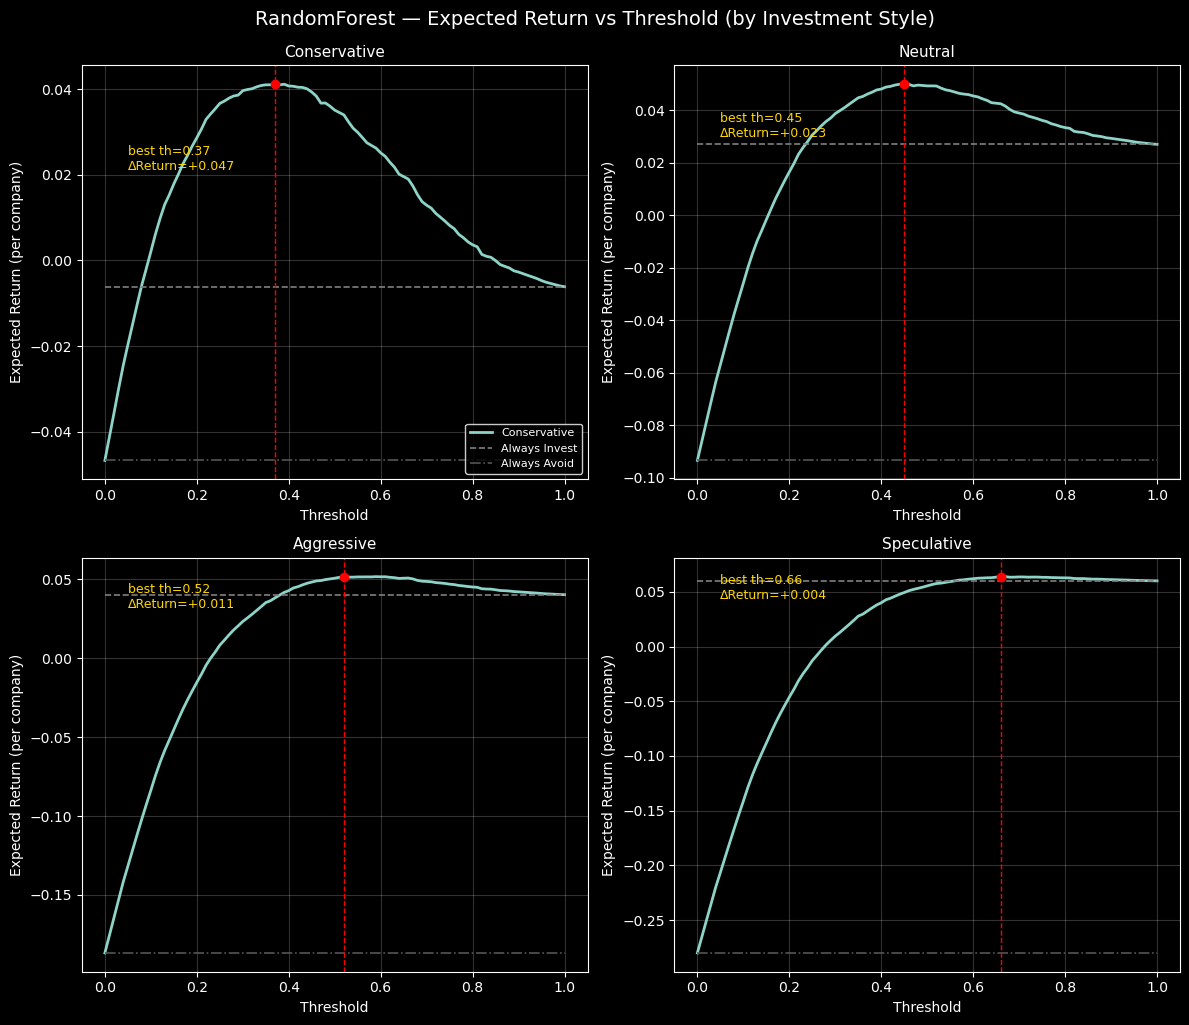

RandomForest summary (per style):
  Conservative Best th=0.37  Best ret=0.0411
  Neutral      Best th=0.45  Best ret=0.0499
  Aggressive   Best th=0.52  Best ret=0.0517
  Speculative  Best th=0.66  Best ret=0.0640


In [35]:
# Random Forest (train, plot, save)
"""
Train RandomForest, compute expected-return curve (for each investment style),
plot a single figure with curve + baselines + best point, and save it.
"""
from sklearn.ensemble import RandomForestClassifier

model_name = "RandomForest"
rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced")
rf.fit(X_train_res, y_train_res)

# predicted probabilities on test
y_proba = rf.predict_proba(X_test_scaled)[:, 1]

# create 2x2 subplots: one for each style
plt.style.use("dark_background")
plt.figure(figsize=(12, 10))
plot_idx = 1

for style_name, cost_mat in styles.items():
    returns = np.array([expected_return(y_test.reset_index(drop=True), y_proba, th, cost_mat) for th in thresholds])
    best_idx = returns.argmax()
    best_th = thresholds[best_idx]
    best_ret = returns[best_idx]

    # save numeric results
    model_results[f"{model_name}_{style_name}"] = {
        "thresholds": thresholds,
        "returns": returns,
        "best_threshold": best_th,
        "best_return": best_ret,
        "cost_matrix": cost_mat
    }

    ax = plt.subplot(2, 2, plot_idx)
    ax.plot(thresholds, returns, linewidth=2, label=f"{style_name}")
    # baselines for this style
    ret_invest, ret_avoid = baseline_return_for_style(y_test, cost_mat)
    ax.hlines(ret_invest, 0, 1, colors='gray', linestyles='--', linewidth=1.2, label='Always Invest')
    ax.hlines(ret_avoid, 0, 1, colors='#555555', linestyles='-.', linewidth=1.2, label='Always Avoid')

    # mark best
    ax.scatter([best_th], [best_ret], color='red', zorder=5)
    ax.axvline(best_th, color='red', linestyle='--', linewidth=1)
    delta = best_ret - ret_invest
    ax.text(0.05, best_ret - 0.02, f"best th={best_th:.2f}\nΔReturn={delta:+.3f}", color='gold', fontsize=9)

    ax.set_title(f"{style_name}", fontsize=11, color='white')
    ax.set_xlabel("Threshold", color='white')
    ax.set_ylabel("Expected Return (per company)", color='white')
    ax.grid(alpha=0.2)
    ax.tick_params(colors='white')
    if plot_idx == 1:
        ax.legend(loc='lower right', fontsize=8, facecolor='black', edgecolor='white')
    plot_idx += 1

plt.tight_layout()
plt.suptitle("RandomForest — Expected Return vs Threshold (by Investment Style)", y=1.02, fontsize=14, color='white')
plt.savefig("rf_expected_return_by_style.png", dpi=300, bbox_inches='tight', facecolor='black')
plt.show()

# short summary
print("RandomForest summary (per style):")
for style_name in styles:
    v = model_results[f"{model_name}_{style_name}"]
    print(f"  {style_name:12s} Best th={v['best_threshold']:.2f}  Best ret={v['best_return']:.4f}")


J:\anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:18:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


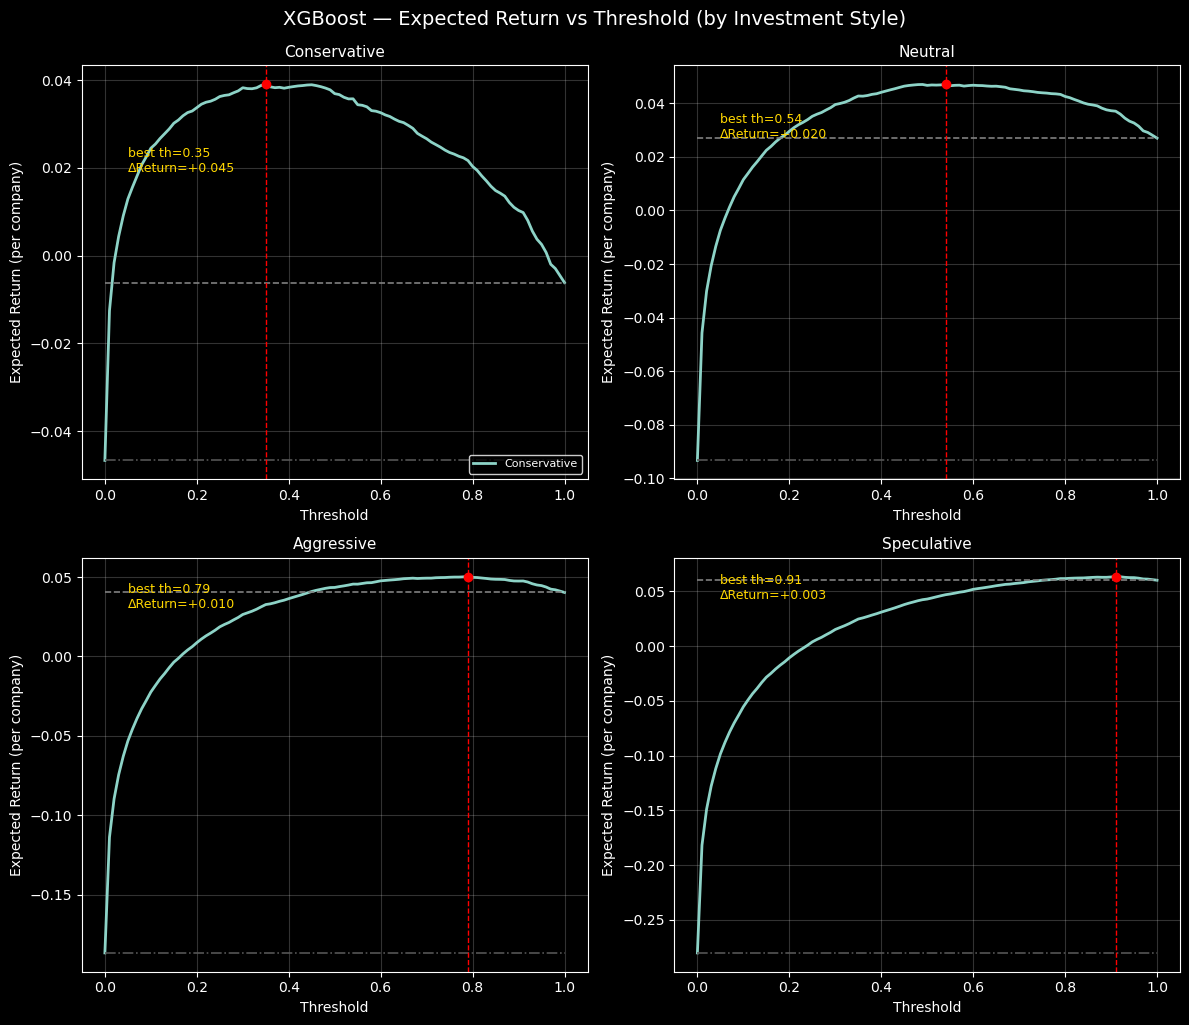

XGBoost summary (per style):
  Conservative Best th=0.35  Best ret=0.0391
  Neutral      Best th=0.54  Best ret=0.0472
  Aggressive   Best th=0.79  Best ret=0.0502
  Speculative  Best th=0.91  Best ret=0.0635


In [37]:
# XGBoost (train, plot, save)
"""
Train XGBoost, plot expected return curve for each investment style in one figure,
and store results for later comparison.
"""
from xgboost import XGBClassifier

model_name = "XGBoost"
# compute scale_pos_weight to mimic class_balance in resampled set (optional since we used SMOTE)
pos = np.sum(y_train_res == 1)
neg = np.sum(y_train_res == 0)
scale_pos_weight = (neg / (pos + 1e-9))

xgb = XGBClassifier(n_estimators=300, random_state=42, use_label_encoder=False, eval_metric='logloss',
                    scale_pos_weight=scale_pos_weight)
xgb.fit(X_train_res, y_train_res)
y_proba = xgb.predict_proba(X_test_scaled)[:, 1]

plt.style.use("dark_background")
plt.figure(figsize=(12, 10))
plot_idx = 1

for style_name, cost_mat in styles.items():
    returns = np.array([expected_return(y_test.reset_index(drop=True), y_proba, th, cost_mat) for th in thresholds])
    best_idx = returns.argmax()
    best_th = thresholds[best_idx]
    best_ret = returns[best_idx]

    model_results[f"{model_name}_{style_name}"] = {
        "thresholds": thresholds,
        "returns": returns,
        "best_threshold": best_th,
        "best_return": best_ret,
        "cost_matrix": cost_mat
    }

    ax = plt.subplot(2, 2, plot_idx)
    ax.plot(thresholds, returns, linewidth=2, label=f"{style_name}")
    ret_invest, ret_avoid = baseline_return_for_style(y_test, cost_mat)
    ax.hlines(ret_invest, 0, 1, colors='gray', linestyles='--', linewidth=1.2)
    ax.hlines(ret_avoid, 0, 1, colors='#555555', linestyles='-.', linewidth=1.2)

    ax.scatter([best_th], [best_ret], color='red', zorder=5)
    ax.axvline(best_th, color='red', linestyle='--', linewidth=1)
    delta = best_ret - ret_invest
    ax.text(0.05, best_ret - 0.02, f"best th={best_th:.2f}\nΔReturn={delta:+.3f}", color='gold', fontsize=9)

    ax.set_title(f"{style_name}", fontsize=11, color='white')
    ax.set_xlabel("Threshold", color='white')
    ax.set_ylabel("Expected Return (per company)", color='white')
    ax.grid(alpha=0.2)
    ax.tick_params(colors='white')
    if plot_idx == 1:
        ax.legend(loc='lower right', fontsize=8, facecolor='black', edgecolor='white')
    plot_idx += 1

plt.tight_layout()
plt.suptitle("XGBoost — Expected Return vs Threshold (by Investment Style)", y=1.02, fontsize=14, color='white')
plt.savefig("xgb_expected_return_by_style.png", dpi=300, bbox_inches='tight', facecolor='black')
plt.show()

print("XGBoost summary (per style):")
for style_name in styles:
    v = model_results[f"{model_name}_{style_name}"]
    print(f"  {style_name:12s} Best th={v['best_threshold']:.2f}  Best ret={v['best_return']:.4f}")


Logistic ROC-AUC: 0.6728


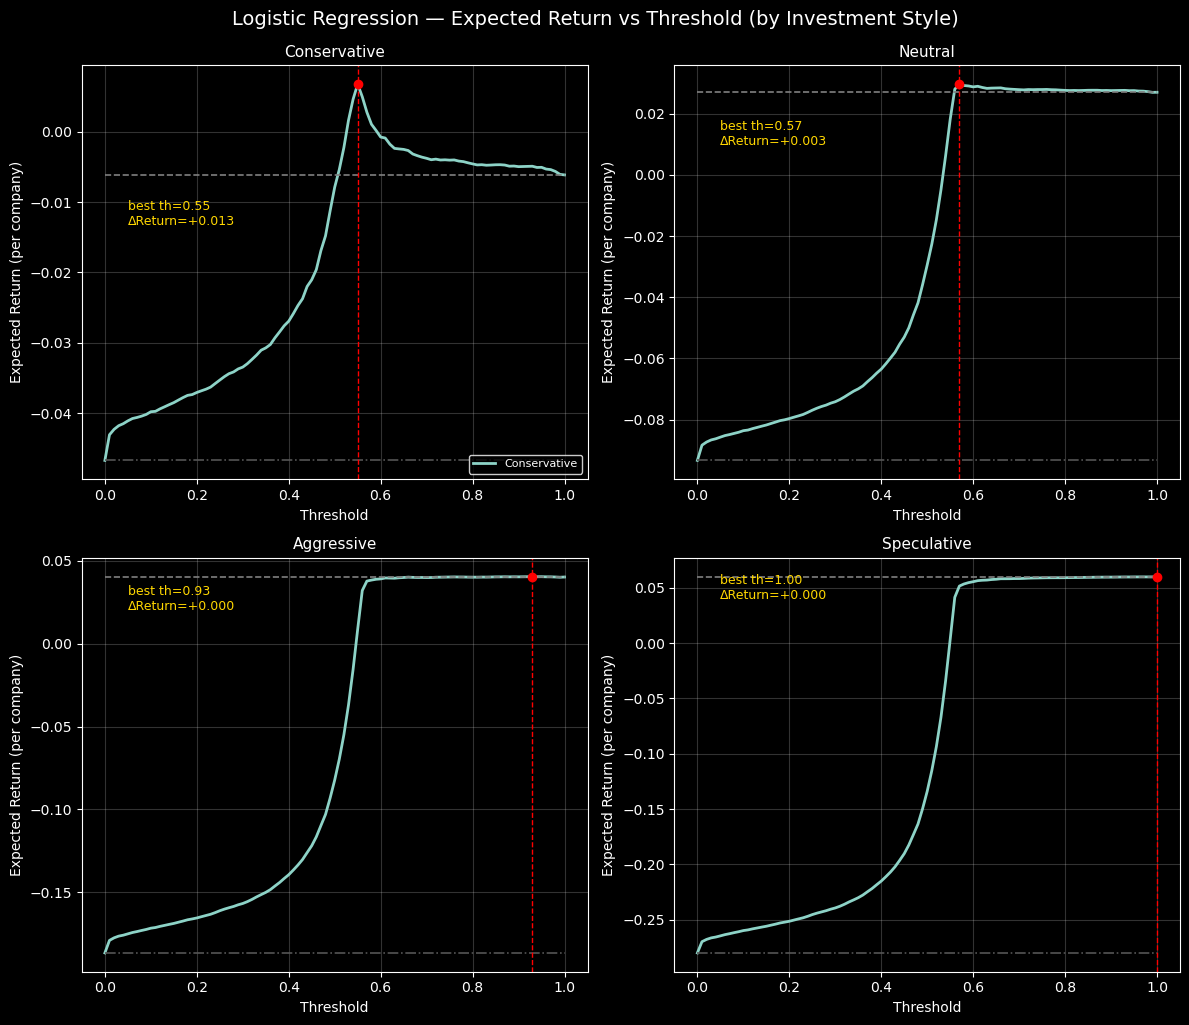

Logistic summary (per style):
  Conservative Best th=0.55  Best ret=0.0067
  Neutral      Best th=0.57  Best ret=0.0297
  Aggressive   Best th=0.93  Best ret=0.0405
  Speculative  Best th=1.00  Best ret=0.0602


In [39]:
# Logistic Regression (train, plot, save)
"""
Train Logistic Regression, plot expected-return curves, save results.
"""
from sklearn.linear_model import LogisticRegression

model_name = "Logistic"
logit = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=5000,
                           random_state=42, class_weight='balanced')
logit.fit(X_train_res, y_train_res)
y_proba = logit.predict_proba(X_test_scaled)[:, 1]

try:
    print("Logistic ROC-AUC:", round(roc_auc_score(y_test, y_proba), 4))
except Exception:
    pass

plt.style.use("dark_background")
plt.figure(figsize=(12, 10))
plot_idx = 1

for style_name, cost_mat in styles.items():
    returns = np.array([expected_return(y_test.reset_index(drop=True), y_proba, th, cost_mat) for th in thresholds])
    best_idx = returns.argmax()
    best_th = thresholds[best_idx]
    best_ret = returns[best_idx]

    model_results[f"{model_name}_{style_name}"] = {
        "thresholds": thresholds,
        "returns": returns,
        "best_threshold": best_th,
        "best_return": best_ret,
        "cost_matrix": cost_mat
    }

    ax = plt.subplot(2, 2, plot_idx)
    ax.plot(thresholds, returns, linewidth=2, label=f"{style_name}")
    ret_invest, ret_avoid = baseline_return_for_style(y_test, cost_mat)
    ax.hlines(ret_invest, 0, 1, colors='gray', linestyles='--', linewidth=1.2)
    ax.hlines(ret_avoid, 0, 1, colors='#555555', linestyles='-.', linewidth=1.2)

    ax.scatter([best_th], [best_ret], color='red', zorder=5)
    ax.axvline(best_th, color='red', linestyle='--', linewidth=1)
    delta = best_ret - ret_invest
    ax.text(0.05, best_ret - 0.02, f"best th={best_th:.2f}\nΔReturn={delta:+.3f}", color='gold', fontsize=9)

    ax.set_title(f"{style_name}", fontsize=11, color='white')
    ax.set_xlabel("Threshold", color='white')
    ax.set_ylabel("Expected Return (per company)", color='white')
    ax.grid(alpha=0.2)
    ax.tick_params(colors='white')
    if plot_idx == 1:
        ax.legend(loc='lower right', fontsize=8, facecolor='black', edgecolor='white')
    plot_idx += 1

plt.tight_layout()
plt.suptitle("Logistic Regression — Expected Return vs Threshold (by Investment Style)", y=1.02, fontsize=14, color='white')
plt.savefig("logit_expected_return_by_style.png", dpi=300, bbox_inches='tight', facecolor='black')
plt.show()

print("Logistic summary (per style):")
for style_name in styles:
    v = model_results[f"{model_name}_{style_name}"]
    print(f"  {style_name:12s} Best th={v['best_threshold']:.2f}  Best ret={v['best_return']:.4f}")


Calibrated LinearSVC ROC-AUC: 0.6632


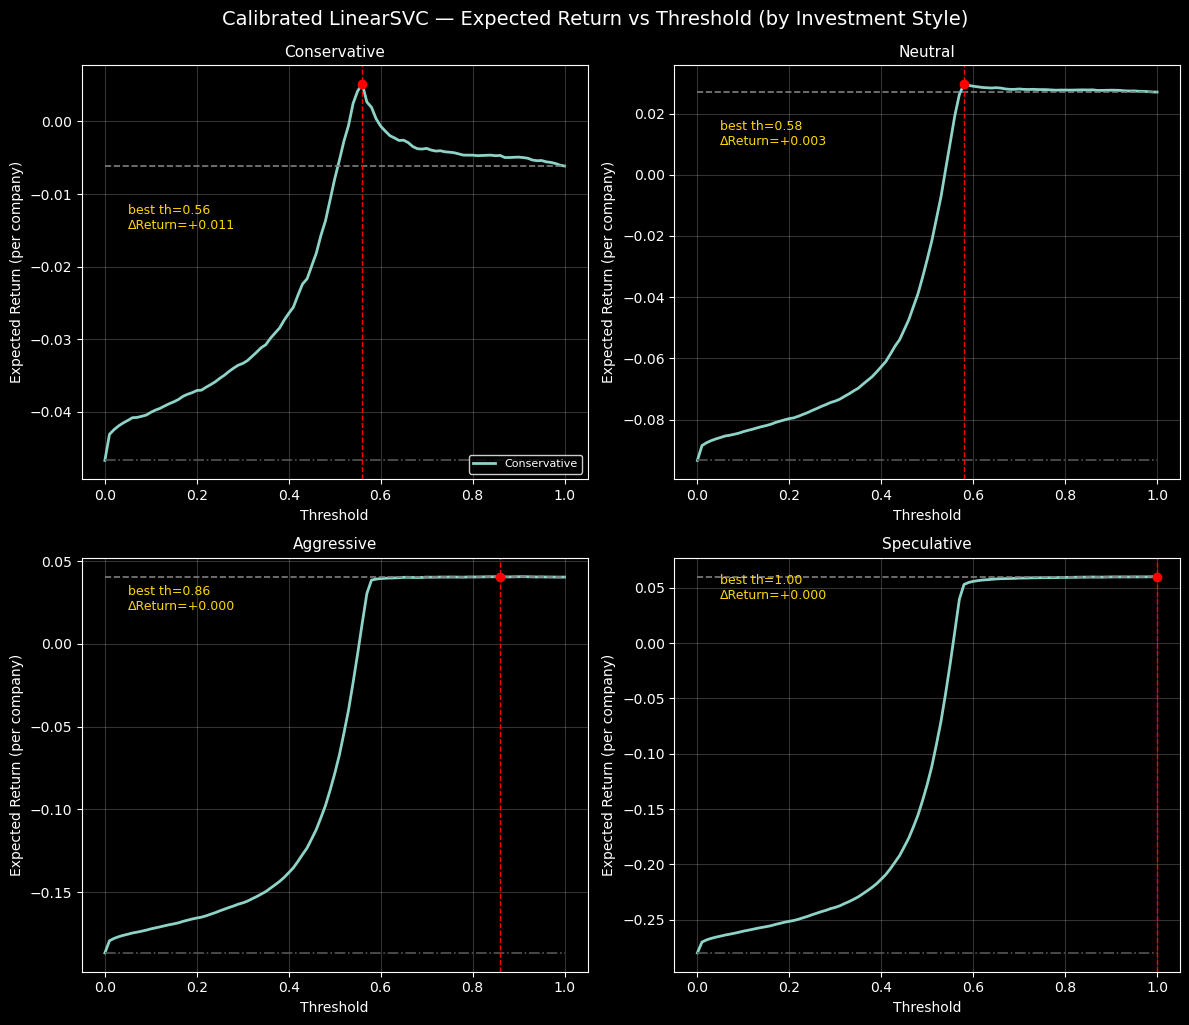

SVM summary (per style):
  Conservative Best th=0.56  Best ret=0.0051
  Neutral      Best th=0.58  Best ret=0.0296
  Aggressive   Best th=0.86  Best ret=0.0406
  Speculative  Best th=1.00  Best ret=0.0602


In [41]:
# SVM (calibrated LinearSVC) (train, plot, save)
"""
Train a calibrated LinearSVC to obtain probabilities, then plot expected-return curves.
"""
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

model_name = "SVM"
lsvc = LinearSVC(C=1.0, class_weight='balanced', max_iter=5000, random_state=42)
calibrated = CalibratedClassifierCV(lsvc, method='sigmoid', cv=5)
calibrated.fit(X_train_res, y_train_res)
y_proba = calibrated.predict_proba(X_test_scaled)[:, 1]

try:
    print("Calibrated LinearSVC ROC-AUC:", round(roc_auc_score(y_test, y_proba), 4))
except Exception:
    pass

plt.style.use("dark_background")
plt.figure(figsize=(12, 10))
plot_idx = 1

for style_name, cost_mat in styles.items():
    returns = np.array([expected_return(y_test.reset_index(drop=True), y_proba, th, cost_mat) for th in thresholds])
    best_idx = returns.argmax()
    best_th = thresholds[best_idx]
    best_ret = returns[best_idx]

    model_results[f"{model_name}_{style_name}"] = {
        "thresholds": thresholds,
        "returns": returns,
        "best_threshold": best_th,
        "best_return": best_ret,
        "cost_matrix": cost_mat
    }

    ax = plt.subplot(2, 2, plot_idx)
    ax.plot(thresholds, returns, linewidth=2, label=f"{style_name}")
    ret_invest, ret_avoid = baseline_return_for_style(y_test, cost_mat)
    ax.hlines(ret_invest, 0, 1, colors='gray', linestyles='--', linewidth=1.2)
    ax.hlines(ret_avoid, 0, 1, colors='#555555', linestyles='-.', linewidth=1.2)

    ax.scatter([best_th], [best_ret], color='red', zorder=5)
    ax.axvline(best_th, color='red', linestyle='--', linewidth=1)
    delta = best_ret - ret_invest
    ax.text(0.05, best_ret - 0.02, f"best th={best_th:.2f}\nΔReturn={delta:+.3f}", color='gold', fontsize=9)

    ax.set_title(f"{style_name}", fontsize=11, color='white')
    ax.set_xlabel("Threshold", color='white')
    ax.set_ylabel("Expected Return (per company)", color='white')
    ax.grid(alpha=0.2)
    ax.tick_params(colors='white')
    if plot_idx == 1:
        ax.legend(loc='lower right', fontsize=8, facecolor='black', edgecolor='white')
    plot_idx += 1

plt.tight_layout()
plt.suptitle("Calibrated LinearSVC — Expected Return vs Threshold (by Investment Style)", y=1.02, fontsize=14, color='white')
plt.savefig("svm_expected_return_by_style.png", dpi=300, bbox_inches='tight', facecolor='black')
plt.show()

print("SVM summary (per style):")
for style_name in styles:
    v = model_results[f"{model_name}_{style_name}"]
    print(f"  {style_name:12s} Best th={v['best_threshold']:.2f}  Best ret={v['best_return']:.4f}")

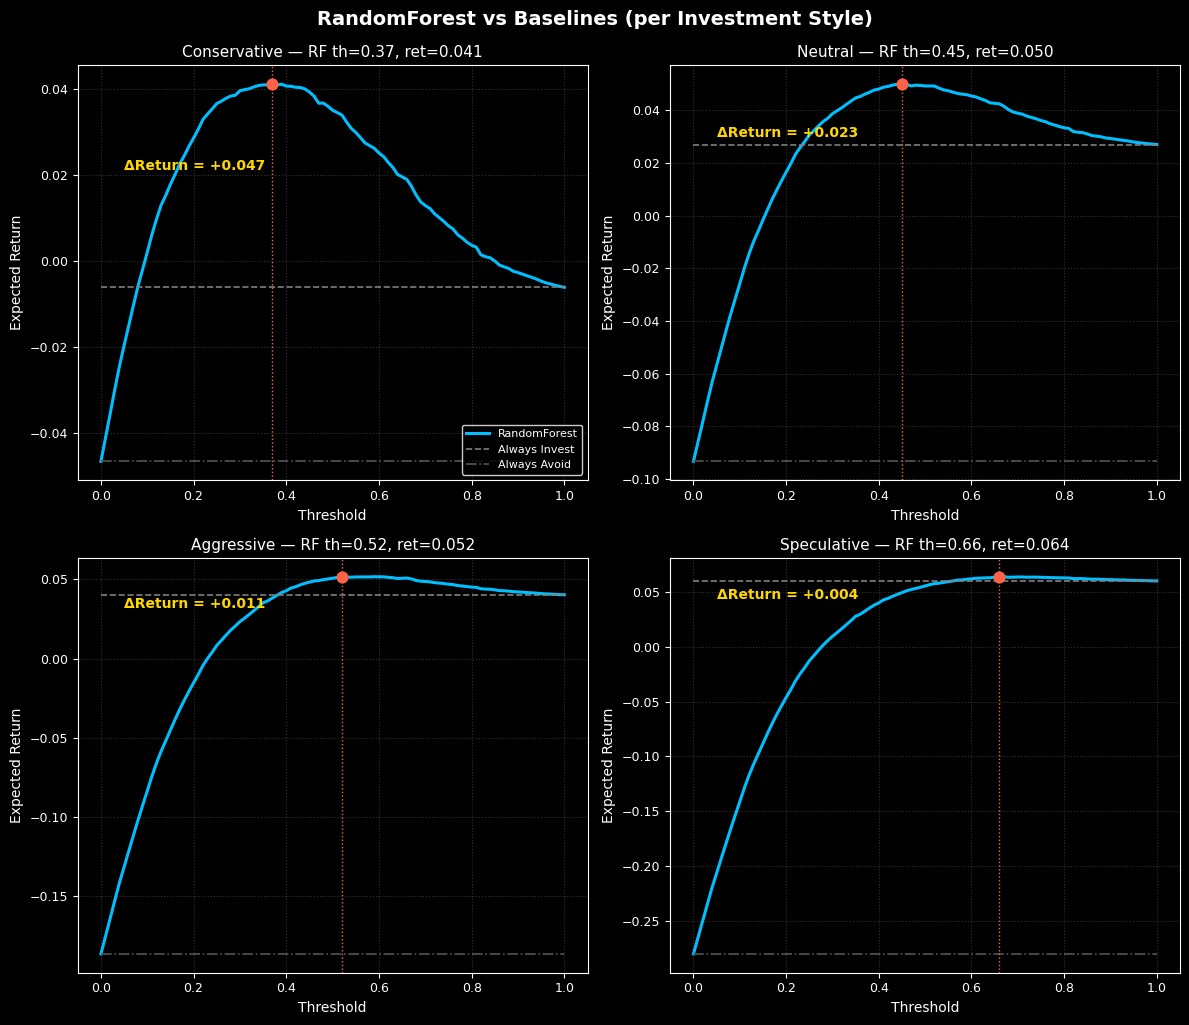

RF vs Baselines comparison (per style):
Conservative RF best ret=0.0411 (th=0.37)  AlwaysInvest=-0.0061  AlwaysAvoid=-0.0467
Neutral      RF best ret=0.0499 (th=0.45)  AlwaysInvest=0.0270  AlwaysAvoid=-0.0934
Aggressive   RF best ret=0.0517 (th=0.52)  AlwaysInvest=0.0403  AlwaysAvoid=-0.1867
Speculative  RF best ret=0.0640 (th=0.66)  AlwaysInvest=0.0602  AlwaysAvoid=-0.2801


In [29]:
# RandomForest vs Baselines comparison (detailed)
"""
Final comparison: plot RandomForest expected-return curve for each style and overlay baseline lines.
Also print numeric comparison (best RF return vs AlwaysInvest / AlwaysAvoid).
This cell expects that the RandomForest results are stored in model_results from Cell 2.
If you didn't run Cell 2, re-run it or retrain RF here.
"""
import matplotlib.pyplot as plt

# Ensure RF results exist; if not, retrain RF quickly (safe-guard)
rf_key_example = "RandomForest_Conservative"
if rf_key_example not in model_results:
    print("RandomForest results not found in model_results — retraining RandomForest now.")
    from sklearn.ensemble import RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced")
    rf.fit(X_train_res, y_train_res)
    y_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]
    for style_name, cost_mat in styles.items():
        returns = np.array([expected_return(y_test.reset_index(drop=True), y_proba_rf, th, cost_mat) for th in thresholds])
        best_idx = returns.argmax()
        best_th = thresholds[best_idx]
        best_ret = returns[best_idx]
        model_results[f"RandomForest_{style_name}"] = {
            "thresholds": thresholds,
            "returns": returns,
            "best_threshold": best_th,
            "best_return": best_ret,
            "cost_matrix": cost_mat
        }
else:
    # use stored RF probabilities if available: reconstruct y_proba from stored returns (no direct proba stored)
    # For strict reproducibility you'd want to keep y_proba from RF in model_results earlier.
    pass

# Plot RF curves and baseline lines style-by-style (4 subplots)
plt.style.use("dark_background")
plt.figure(figsize=(12, 10))
plot_idx = 1
for style_name, cost_mat in styles.items():
    v = model_results[f"RandomForest_{style_name}"]
    ax = plt.subplot(2, 2, plot_idx)
    ax.plot(v["thresholds"], v["returns"], color='#00BFFF', linewidth=2.2, label='RandomForest')

    # baseline returns for this style
    ret_invest, ret_avoid = baseline_return_for_style(y_test, cost_mat)
    ax.hlines(ret_invest, xmin=0, xmax=1, colors='gray', linestyles='--', linewidth=1.2, label='Always Invest')
    ax.hlines(ret_avoid, xmin=0, xmax=1, colors='#555555', linestyles='-.', linewidth=1.2, label='Always Avoid')

    # mark best RF point
    ax.scatter(v["best_threshold"], v["best_return"], color='#FF6347', s=60, zorder=5)
    ax.axvline(v["best_threshold"], color='#FF6347', linestyle=':', linewidth=1)

    delta = v["best_return"] - ret_invest
    ax.text(0.05, v["best_return"] - 0.02, f"ΔReturn = {delta:+.3f}", color='gold', fontsize=10, weight='bold')

    ax.set_title(f"{style_name} — RF th={v['best_threshold']:.2f}, ret={v['best_return']:.3f}", fontsize=11, color='white')
    ax.set_xlabel("Threshold", color='white')
    ax.set_ylabel("Expected Return", color='white')
    ax.tick_params(colors='white', labelsize=9)
    ax.grid(alpha=0.2, linestyle=':')
    if plot_idx == 1:
        ax.legend(loc='lower right', fontsize=8, facecolor='black', edgecolor='white')
    plot_idx += 1

plt.tight_layout()
plt.suptitle("RandomForest vs Baselines (per Investment Style)", y=1.02, fontsize=14, color='white', weight='bold')
plt.savefig("rf_vs_baselines_detailed.png", dpi=300, bbox_inches='tight', facecolor='black')
plt.show()

# Print numeric comparison summary
print("RF vs Baselines comparison (per style):")
for style_name, cost_mat in styles.items():
    v = model_results[f"RandomForest_{style_name}"]
    ret_invest, ret_avoid = baseline_return_for_style(y_test, cost_mat)
    print(f"{style_name:12s} RF best ret={v['best_return']:.4f} (th={v['best_threshold']:.2f})  AlwaysInvest={ret_invest:.4f}  AlwaysAvoid={ret_avoid:.4f}")
